In [5]:
%load_ext autoreload
%autoreload 2

import os,sys,warnings
import h5py, pandas
import numpy as np
np.seterr(invalid=['ignore','warn'][0])
np.set_printoptions(legacy='1.25')
import math,cmath,pickle
from matplotlib.backends.backend_pdf import PdfPages
from scipy.optimize import curve_fit,fsolve
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('default')
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.titlesize'] = 20
mpl.rcParams['figure.figsize'] = [6.4*1.2,4.8*1.2]
mpl.rcParams['axes.labelsize'] = 24
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['lines.marker'] = 's'
mpl.rcParams['lines.linestyle'] = ''
mpl.rcParams['lines.markersize'] = 6
mpl.rcParams['errorbar.capsize'] = 6
mpl.rcParams['xtick.labelsize'] = mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['xtick.major.size'] = mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['xtick.top']=mpl.rcParams['ytick.right']=True
mpl.rcParams['xtick.direction']=mpl.rcParams['ytick.direction']='in'
mpl.rcParams['legend.fontsize'] = 24
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

# mpl.rcParams.update({"axes.grid" : True})
import util as yu
yu.flag_fast=False

enss=['b','c','d','e']
enss=['b','c','d']
ens2full={'a24':'cA211.53.24','a':'cA2.09.48','b':'cB211.072.64','c':'cC211.060.80','d':'cD211.054.96','e':'cE211.044.112'}
ens2label={'a24':'A24','a':'A48','b':'B64','c':'C80','d':'D96','e':'E112'}
ens2a={'a24':0.0908,'a':0.0938,'b':0.07957,'c':0.06821,'d':0.05692,'e':0.04892} # fm
ens2N={'a24':24,'a':48,'b':64,'c':80,'d':96,'e':112}
ens2N_T={'a24':24*2,'a':48*2,'b':64*2,'c':80*2,'d':96*2,'e':112*2}

# ens2mN={'a':931}
# ens2mpiC={'a':131}
# ens2mpi0={'a':111}

hbarc = 1/197.3
ens2aInv={ens:1/(ens2a[ens]*hbarc) for ens in enss} # MeV

baseFigPath='fig/analysis_A20/'

def find_t_cloest(ens,t):
    return round(t/ens2a[ens])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
ens2Njk={}
for ens in enss:
    path=f'/p/project1/ngff/li47/code/scratch/run/02_discNJN_1D_run2/{ens2full[ens]}/data_merge/data.h5'
    path=f'/capstor/store/cscs/userlab/lp139/lyan/code/temp/analysis_A20.h5'
    with h5py.File(path) as f:        
        ens2Njk[ens]=len(f[f'{ens}/mom0/N'])

path='data_aux/RCs.pkl'
with open(path,'rb') as f:
    ens2RCs_me=pickle.load(f)
ens2RCs={ens:{} for ens in enss}
for ens in enss:
    for key in ens2RCs_me[ens]:
        if key.endswith('err'):
            continue
        ens2RCs[ens][key]=yu.jackknife_pseudo([ens2RCs_me[ens][key]],np.array([[ens2RCs_me[ens][f'{key}_err']**2+1e-10]]),ens2Njk[ens])[:,0]

In [3]:
data={}
for ens in enss:
    path=f'/p/project1/ngff/li47/code/scratch/run/02_discNJN_1D_run2/{ens2full[ens]}/data_merge/data.h5'
    path=f'/capstor/store/cscs/userlab/lp139/lyan/code/temp/analysis_A20.h5'
    with h5py.File(path) as f:        
        data[ens]=yu.jackknife(np.real(f[f'{ens}/mom0/N'][:,:,0])) 

propThreshold=0.1
# propThreshold=None

chi2Size=9
settings={}

func_C2pt_1st=lambda t,E0,c0: c0*np.exp(-E0*t)
func_C2pt_2st=lambda t,E0,c0,dE1,rc1: c0*np.exp(-E0*t)*(1 + rc1*np.exp(-dE1*t))
func_C2pt_3st=lambda t,E0,c0,dE1,rc1,dE2,rc2: c0*np.exp(-E0*t)*(1 + rc1*np.exp(-dE1*t) + rc2*np.exp(-dE2*t))
func_mEff_1st=lambda t,E0: np.log(func_C2pt_1st(t,E0,1)/func_C2pt_1st(t+1,E0,1))
func_mEff_2st=lambda t,E0,dE1,rc1: np.log(func_C2pt_2st(t,E0,1,dE1,rc1)/func_C2pt_2st(t+1,E0,1,dE1,rc1))
func_mEff_3st=lambda t,E0,dE1,rc1,dE2,rc2: np.log(func_C2pt_3st(t,E0,1,dE1,rc1,dE2,rc2)/func_C2pt_3st(t+1,E0,1,dE1,rc1,dE2,rc2))

def run(ens,figname=None):
    corrQ=True; meffQ=True
    xunit=ens2a[ens]; yunit=ens2aInv[ens]/1000
    fig, axd = plt.subplot_mosaic([['f1','f1','f1'],['f2','f2','f3']],figsize=(24,10))
    (ax1,ax2,ax3)=(axd[key] for key in ['f1','f2','f3'])
    # if meffQ:
    #     fig.suptitle('Correlated fit to meff' if corrQ else 'Uncorrelated fit to meff',fontsize=44)
    # else:
    #     fig.suptitle('Correlated fit to C2pt' if corrQ else 'Uncorrelated fit to C2pt',fontsize=44)
    
    ax1.set_xlabel(r'$t$ [fm]')
    ax2.set_xlabel(r'$t_{\mathrm{min}}$ [fm]')
    ax3.set_xlabel(r'$t_{\mathrm{min}}$ [fm]')
    ax1.set_ylabel(r'$m_N^{\mathrm{eff}}$ [GeV]')
    ax2.set_ylabel(r'$m_N$ [GeV]')
    ax3.set_ylabel(r'$E_1$ [GeV]')
    ax1.set_ylim(settings['ylim1'])
    ax2.set_ylim(settings['ylim2'])
    ax3.set_ylim(settings['ylim3'])
    ax1.set_xlim(settings['xlim1'])
    ax2.set_xlim(settings['xlim2'])
    ax3.set_xlim(settings['xlim3'])
    
    mN_exp=0.938; mp_exp,mn_exp=(0.93827,0.93957)
    ax1.axhline(y=mN_exp,color='black',linestyle = '--', marker='')
    ax2.axhline(y=mN_exp,color='black',linestyle = '--', marker='', label=r'$m_N^{\mathrm{exp}}=$'+'%0.3f'%mN_exp)
    C2pt_jk=data[ens]
    C2pt_mean,C2pt_err=yu.jackme(C2pt_jk)
    C2pt_rela=np.abs(C2pt_err/C2pt_mean)
    func=lambda C2pt: np.log(C2pt/np.roll(C2pt,-1,axis=0))
    mEff_jk=yu.jackmap(func,C2pt_jk)
    (mEff_mean,mEff_err)=yu.jackme(mEff_jk)
    mEff_rela=np.abs(mEff_err/mEff_mean)
    temp=[(i,rela) for i,rela in enumerate(mEff_rela if meffQ else C2pt_rela) if rela>0.2 and i!=0]
    fitmax=temp[0][0]-1 if len(temp)!=0 else len(C2pt_mean)-1
    
    tmin=1; tmax=fitmax+1
    plt_x=np.arange(tmin,tmax)*xunit; plt_y=mEff_mean[tmin:tmax]*yunit; plt_err=mEff_err[tmin:tmax]*yunit
    ax1.errorbar(plt_x,plt_y,plt_err,color='black',fmt='s')

    pars0_initial=[0.4,0.5,2,0.8,1] if meffQ else [0.4,1e-8,0.5,2,0.8,1]
    DNpar=1 if meffQ else 0
    
    fits_all=[]
    # 1st fits
    color='r'
    fitmins=settings['fitmins_1st']
    pars0=pars0_initial[:2-DNpar]
    fits=[]
    for fitmin in fitmins:
        tList=np.arange(fitmin,fitmax,2)
        def fitfunc(pars):
            if meffQ:
                return func_mEff_1st(tList,*pars)
            return func_C2pt_1st(tList,*pars)
        y_jk=mEff_jk[:,tList] if meffQ else C2pt_jk[:,tList]
        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0,mask=None if corrQ else 'uncorrelated')
        pars0=np.mean(pars_jk,axis=0)
        fits.append([fitmin,pars_jk,chi2_jk,Ndof])
        fits_all.append([('1st',fitmin),pars_jk[:,:1],chi2_jk,Ndof])
        
    pars_jk,props_jk=yu.jackMA(fits)
    props_mean=np.mean(props_jk,axis=0)
    ind_mpf=np.argmax(np.mean(props_jk,axis=0))    
    pars_mean,pars_err=yu.jackme(pars_jk)
    pars0=pars_mean
    plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
    ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2,label=r'$m_N^{\mathrm{1st}}=$'+yu.un2str(plt_y,plt_err))
    for i,fit in enumerate(fits):
        fitmin,pars_jk,chi2_jk,Ndof=fit; prop=props_mean[i]
        (pars_mean,pars_err)=yu.jackme(pars_jk)
        chi2R=np.mean(chi2_jk)/Ndof
        showQ = i==ind_mpf if propThreshold is None else prop>propThreshold
        
        plt_x=fitmin*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
        ax2.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
        ylim=ax2.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax2.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center')
        if propThreshold is not None and prop>propThreshold:
            ax2.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')
            
    # 2st fits
    color='g'
    fitmins=settings['fitmins_2st']
    pars0=np.hstack([pars0,pars0_initial[2-DNpar:4-DNpar]])
    fits=[]
    for fitmin in fitmins:
        # print(2,fitmin)
        tList=np.arange(fitmin,fitmax,2)
        def fitfunc(pars):
            if meffQ:
                return func_mEff_2st(tList,*pars)
            return func_C2pt_2st(tList,*pars)
        y_jk=mEff_jk[:,tList] if meffQ else C2pt_jk[:,tList]
        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0,mask=None if corrQ else 'uncorrelated')
        pars0=np.mean(pars_jk,axis=0)
        fits.append([fitmin,pars_jk,chi2_jk,Ndof])
        fits_all.append([('2st',fitmin),pars_jk[:,:1],chi2_jk,Ndof])
    pars_jk,props_jk=yu.jackMA(fits)
    props_mean=np.mean(props_jk,axis=0)
    res=pars_jk.copy()
    ind_mpf=np.argmax(np.mean(props_jk,axis=0))    
    pars0=yu.jackme(pars_jk)[0]
    pars_jk[:,1]=pars_jk[:,0]+pars_jk[:,2-DNpar]
    pars_mean,pars_err=yu.jackme(pars_jk)
    plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
    ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$m_N^{\mathrm{2st}}=$'+yu.un2str(plt_y,plt_err))
    plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xunit; plt_y=pars_mean[1]*yunit; plt_err=pars_err[1]*yunit
    ax3.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$E_1^{\mathrm{2st}}=$'+yu.un2str(plt_y,plt_err))
    for i,fit in enumerate(fits):
        fitmin,pars_jk,chi2_jk,Ndof=fit; prop=props_mean[i]
        pars_jk[:,1]=pars_jk[:,0]+pars_jk[:,2-DNpar]
        (pars_mean,pars_err)=yu.jackme(pars_jk)
        chi2R=np.mean(chi2_jk)/Ndof
        showQ = i==ind_mpf if propThreshold is None else prop>propThreshold
        
        plt_x=fitmin*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
        ax2.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
        ylim=ax2.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax2.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center')
        if propThreshold is not None and prop>propThreshold:
            ax2.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')
        
        plt_x=fitmin*xunit; plt_y=pars_mean[1]*yunit; plt_err=pars_err[1]*yunit
        ax3.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
        ylim=ax3.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax3.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center')
        if propThreshold is not None and prop>propThreshold:
            ax3.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')

    # 3st fits
    color='b'
    fitmins=settings['fitmins_3st']
    pars0=np.hstack([pars0,pars0_initial[4-DNpar:6-DNpar]])
    if ens=='c' and (corrQ,meffQ)==(False,False):
        pars0=[3.25069715e-01, 1.88384811e-09, 1.78883939e-01, 6.35351339e-01, 6.98775484e-01, 4.58702896e+01]
    # elif ens=='d' and (corrQ,meffQ)==(False,False):
    #     pars=[2.72824764e-01, 3.72721072e-10, 1.84246641e-01, 7.65383428e-01, 6.98775484e-01, 4.58702896e+01]
    fits=[]
    for fitmin in fitmins:
        # print(3,fitmin)
        tList=np.arange(fitmin,fitmax,2)
        def fitfunc(pars):
            if meffQ:
                return func_mEff_3st(tList,*pars)
            return func_C2pt_3st(tList,*pars)
        y_jk=mEff_jk[:,tList] if meffQ else C2pt_jk[:,tList]
        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0,mask=None if corrQ else 'uncorrelated')
        pars0=np.mean(pars_jk,axis=0)
        fits.append([fitmin,pars_jk,chi2_jk,Ndof])
        fits_all.append([('3st',fitmin),pars_jk[:,:1],chi2_jk,Ndof])
    pars_jk,props_jk=yu.jackMA(fits)
    props_mean=np.mean(props_jk,axis=0)
    ind_mpf=np.argmax(np.mean(props_jk,axis=0))    
    pars0=yu.jackme(pars_jk)[0]
    # print(pars0)
    pars_jk[:,1]=pars_jk[:,0]+pars_jk[:,2-DNpar]
    pars_mean,pars_err=yu.jackme(pars_jk)
    plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
    ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$m_N^{\mathrm{3st}}=$'+yu.un2str(plt_y,plt_err))
    plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xunit; plt_y=pars_mean[1]*yunit; plt_err=pars_err[1]*yunit
    ax3.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$E_1^{\mathrm{3st}}=$'+yu.un2str(plt_y,plt_err))    
    for i,fit in enumerate(fits):
        fitmin,pars_jk,chi2_jk,Ndof=fit; prop=props_mean[i]
        pars_jk[:,1]=pars_jk[:,0]+pars_jk[:,2-DNpar]
        (pars_mean,pars_err)=yu.jackme(pars_jk)
        chi2R=np.mean(chi2_jk)/Ndof
        showQ = i==ind_mpf if propThreshold is None else prop>propThreshold
        
        plt_x=fitmin*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
        ax2.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
        ylim=ax2.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax2.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center')
        if propThreshold is not None and prop>propThreshold:
            ax2.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')
        
        plt_x=fitmin*xunit; plt_y=pars_mean[1]*yunit; plt_err=pars_err[1]*yunit
        ax3.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
        ylim=ax3.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax3.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center') 
        if propThreshold is not None and prop>propThreshold:
            ax3.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')
        
    color='orange'
    pars_jk,props_jk=yu.jackMA(fits_all)
    ind_mpf=np.argmax(np.mean(props_jk,axis=0))
    pars_mean,pars_err=yu.jackme(pars_jk)
    plt_x=settings['xlim2']; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
    ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$m_N^{\mathrm{nst}}=$'+yu.un2str(plt_y,plt_err) + f'; MPF: {fits_all[ind_mpf][0][0]}')    
    
    ax2.legend(loc=(0.6,0.5),fontsize=12)
    ax3.legend(fontsize=12)
    
    plt.tight_layout()
    # plt.savefig(figname)
    plt.close()
    return res

res_c2ptN0={}
for ens in enss[:]:
    if ens=='b':
        settings={
            'fitmins_1st':range(8,24+1),
            'fitmins_2st':range(1,10+1),
            'fitmins_3st':range(1,4+1),
            'ylim1':[0.6,1.7],
            'ylim1':[0.88,1.08],
            'ylim2':[0.85,1.1],
            'ylim3':[0.85,3.0],
            'xlim1':[0,2.7],
            'xlim2':[0,2.2],
            'xlim3':[0,1.1],
        }
    elif ens=='c':
        settings={
            'fitmins_1st':range(8,29+1),
            'fitmins_2st':range(1,17+1),
            'fitmins_3st':range(1,7+1),
            'ylim1':[0.6,1.7],
            'ylim1':[0.88,1.08],
            'ylim2':[0.85,1.1],
            'ylim3':[0.85,3.0],
            'xlim1':[0,2.7],
            'xlim2':[0,2.2],
            'xlim3':[0,1.1],
        }
    elif ens=='d':
        settings={
            'fitmins_1st':range(8,34+1),
            'fitmins_2st':range(1,20+1),
            'fitmins_3st':range(1,6+1),
            'ylim1':[0.6,1.7],
            'ylim1':[0.88,1.08],
            'ylim2':[0.85,1.1],
            'ylim3':[0.85,3.0],
            'xlim1':[0,2.7],
            'xlim2':[0,2.2],
            'xlim3':[0,1.1],
        }
    res_c2ptN0[ens]=run(ens,figname=f'{baseFigPath}fig_ignore/c2ptN0_{ens}.pdf')
    
ens2mN={}
for ens in enss:
    ens2mN[ens]=res_c2ptN0[ens][:,0]

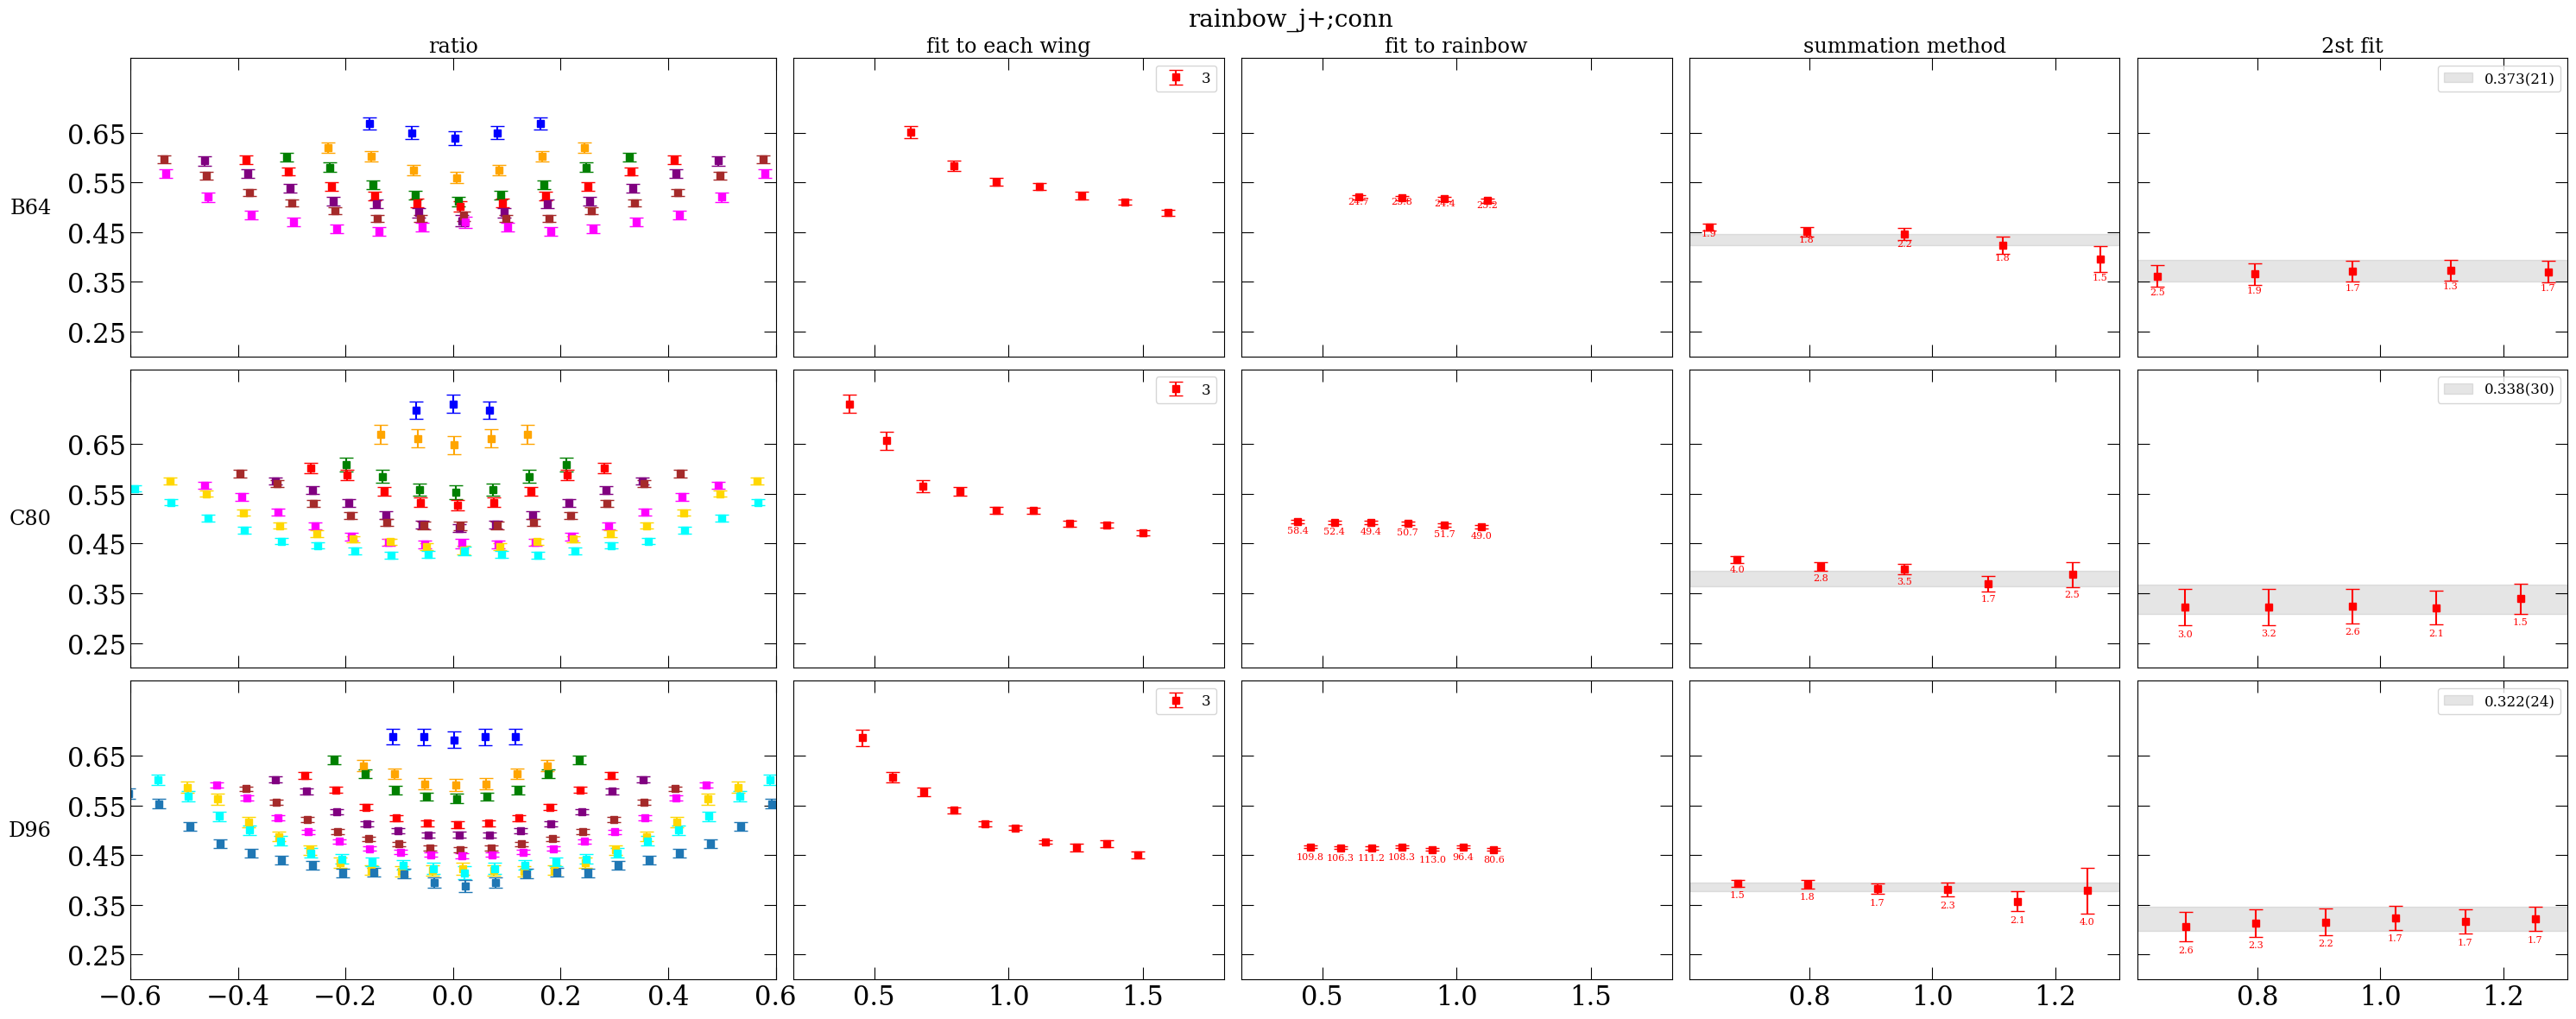

In [24]:
func_C2pt_1st=lambda t,E0,c0: c0*np.exp(-E0*t)
func_C2pt_2st=lambda t,E0,c0,dE1,rc1: c0*np.exp(-E0*t)*(1 + rc1*np.exp(-dE1*t))
func_C2pt_3st=lambda t,E0,c0,dE1,rc1,dE2,rc2: c0*np.exp(-E0*t)*(1 + rc1*np.exp(-dE1*t) + rc2*np.exp(-dE2*t))
func_mEff_1st=lambda t,E0: np.log(func_C2pt_1st(t,E0,1)/func_C2pt_1st(t+1,E0,1))
func_mEff_2st=lambda t,E0,dE1,rc1: np.log(func_C2pt_2st(t,E0,1,dE1,rc1)/func_C2pt_2st(t+1,E0,1,dE1,rc1))
func_mEff_3st=lambda t,E0,dE1,rc1,dE2,rc2: np.log(func_C2pt_3st(t,E0,1,dE1,rc1,dE2,rc2)/func_C2pt_3st(t+1,E0,1,dE1,rc1,dE2,rc2))

func_C3pt_2st=lambda tf,tc,E0a,E0b,a00,dE1a,dE1b,ra01,ra10,ra11: a00*np.exp(-E0a*(tf-tc))*np.exp(-E0b*tc)*(1 + ra01*np.exp(-dE1b*tc) + ra10*np.exp(-dE1a*(tf-tc)) + ra11*np.exp(-dE1a*(tf-tc))*np.exp(-dE1b*tc)) \
    if a00!=0 else np.exp(-E0a*(tf-tc))*np.exp(-E0b*tc)*(ra01*np.exp(-dE1b*tc) + ra10*np.exp(-dE1a*(tf-tc)) + ra11*np.exp(-dE1a*(tf-tc))*np.exp(-dE1b*tc))
func_ratio_2st=lambda tf,tc,g,dE1,rc1,ra01,ra11:func_C3pt_2st(tf,tc,0,0,g,dE1,dE1,ra01,ra01,ra11)/func_C2pt_2st(tf,0,1,dE1,rc1)

def doFit(ens2dat,title,symmetrizeQ=True):
    if len(ens2dat)==0:
        return {}

    fig, axs = yu.getFigAxs(len(ens2dat),5,Lrow=4,Lcol=6,sharex='col',sharey=True, gridspec_kw={'width_ratios': [3, 2, 2, 2, 2]})
    fig.suptitle(title)
    yu.addRowHeader(axs,[ens2label[ens] for ens in enss])
    yu.addColHeader(axs,['ratio','fit to each wing','fit to rainbow','summation method','2st fit'])
    # ax.set
    
    xlims=[[-0.6,0.6],[0.2,1.8],[0.2,1.8]]
    for icol in range(3):
        axs[0,icol].set_xlim(xlims[icol])
    
    key2res={}
    ylims=[]
    for i_ens,key in enumerate(enss):
        if key not in ens2dat.keys():
            continue
        
        tf2ratio=ens2dat[key]
    
        ens=key.split('_')[0]
        
        xunit=ens2a[ens]; yunit=1
        tfs=list(tf2ratio.keys()); tfs.sort()
        
        tfmax_cut=find_t_cloest(ens,1.8)
        
        if symmetrizeQ:
            for tf in tfs:
                tf2ratio[tf]=(tf2ratio[tf]+tf2ratio[tf][:,::-1])/2
                
        colors=['b','orange','g','r','purple','brown','magenta','gold','cyan']
        colors_tcmin=['r','g','b','orange','purple','brown','magenta','gold','cyan']
                        
        tcmins=list(np.arange(2,find_t_cloest(ens,0.3)+1))
        tcmins_model=list(np.arange(find_t_cloest(ens,0.2),find_t_cloest(ens,0.3)+1))
        tcmins=[3]   
        tcmins_model=[3]
        # if ens in ['d']:
        #     tcmins_model=list(np.arange(1,find_t_cloest(ens,0.3)+1))  
        ax=axs[i_ens,1]
        for i_tcmin, tcmin in enumerate(tcmins):
            flag=True
            for i_tf,tf in enumerate(tfs):
                # if tf<tcmin*2:
                #     continue
                ratio=tf2ratio[tf]
                if tf>=2*tcmin:
                    if symmetrizeQ:
                        y_jk=ratio[:,tcmin:tf//2+1]
                    else:
                        y_jk=ratio[:,tcmin:tf-tcmin+1]
                    Ndata=y_jk.shape[1]
                    def fitfunc(pars):
                        return list(pars)*Ndata
                    pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04])
                else:
                    continue
                    # pars_jk=ratio[:,tf//2] if tf%2==0 else (ratio[:,tf//2]+ratio[:,tf//2+1])/2
                    # print(tf,pars_jk.shape)
                
                mean,err=yu.jackme(pars_jk)
                plt_x=(tf+i_tcmin*0.1)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
                ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin],label=f'{tcmin}'if flag else None, mfc='white' if tcmin not in tcmins_model else None)
                flag=False
                
        ax=axs[i_ens,2]
        fits=[]
        for i_tcmin, tcmin in enumerate(tcmins_model):
            tfmins=[tf for tf in tfs[:-3] if tf>=2*tcmin and tf<=tfmax_cut]
            for tfmin in tfmins:
                if tfmin<tcmin*2:
                    continue

                if symmetrizeQ:
                    y_jk=np.concatenate([tf2ratio[tf][:,tcmin:tf//2+1:2] for tf in tfs if tf>=tfmin and tf<=tfmax_cut and tf%2==tfmin%2],axis=1)
                else:
                    y_jk=np.concatenate([tf2ratio[tf][:,tcmin:tf-tcmin+1:2] for tf in tfs if tf>=tfmin and tf<=tfmax_cut and tf%2==tfmin%2],axis=1)

                Ndata=y_jk.shape[1]
                def fitfunc(pars):
                    return list(pars)*Ndata
                # pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04],mask='uncorrelated')
                pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04])
                fits.append([(tcmin,tfmin),pars_jk,chi2_jk,Ndof])
        
        tfmins=list(set([fit[0][1] for fit in fits])); tfmins.sort()
        for tfmin in tfmins:
            t=[fit for fit in fits if fit[0][1]==tfmin]
            pars_jk,props_jk=yu.jackMA(t)
            ind_mpf=np.argmax(np.mean(props_jk,axis=0))
            fitlabel,pars_jk,chi2_jk,Ndof=t[ind_mpf]
            i_tcmin=tcmins.index(fitlabel[0])
            
            mean,err=yu.jackme(pars_jk[:,0])
            plt_x=(tfmin)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
            i_tf=tfs.index(tfmin)
            ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin]) 
            
            chi2R=np.mean(chi2_jk)/Ndof
            ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/24
            ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_yerr-chi2_shift),color=colors_tcmin[i_tcmin],size=8,ha='center')       
            
            
        # pars_jk,props_jk=yu.jackMA(fits)
        # # ind_mpf=np.argmax(np.mean(props_jk,axis=0))
        # pars_mean,pars_err=yu.jackme(pars_jk)
        # key2res[key]=pars_jk[:,0]
                
        ax=axs[i_ens,0]
        # ylim=[pars_mean-pars_err*10,pars_mean+pars_err*10]
        # ylims.append(ylim)
        
        t_cut=2
        for i_tf,tf in enumerate(tfs):
            if tf%2!=0 or tf>tfmax_cut:
                continue
            ratio=tf2ratio[tf]
                
            mean,err=yu.jackme(ratio)
            
            # if err[tf//2]>pars_err*5:
            #     continue
            
            tcs=np.arange(t_cut,tf-t_cut+1)
            plt_x=(tcs-tf/2+0.02*(tf-6))*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
            # plt_x=(tcs-tf/2)*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
            ax.errorbar(plt_x,plt_y,plt_yerr,color=colors[i_tf] if i_tf<len(colors) else None)
            
        # for icol in [0,1,2]:
        #     ax=axs[i_ens,icol]
        #     plt_x=ax.get_xlim(); plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
        #     ax.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='pink',alpha=0.2, label=yu.un2str(plt_y,plt_err) if icol==2 else None) 
            
            
        # summation method
        ax=axs[i_ens,3]
        fits=[]
        for i_tcmin, tcmin in enumerate(tcmins):
            tfmins=[tf for tf in tfs if tf>=2*tcmin and tf<=tfs[-3]]
            for tfmin in tfmins:
                tfs_fit=[tf for tf in tfs if tfmin<=tf<=tfmax_cut]
                y_jk=np.transpose([np.sum(tf2ratio[tf][:,tcmin:tf-tcmin+1],axis=1) for tf in tfs_fit])
                
                def fitfunc(pars):
                    g,c=pars
                    t=np.array([g*tf+c for tf in tfs_fit])
                    return t
                pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04,-1])
                fits.append([(tcmin,tfmin),pars_jk,chi2_jk,Ndof])
                
        tfmins=list(set([fit[0][1] for fit in fits])); tfmins.sort()
        for tfmin in tfmins:
            t=[fit for fit in fits if fit[0][1]==tfmin]
            pars_jk,props_jk=yu.jackMA(t)
            ind_mpf=np.argmax(np.mean(props_jk,axis=0))
            fitlabel,pars_jk,chi2_jk,Ndof=t[ind_mpf]
            i_tcmin=tcmins.index(fitlabel[0])
            
            mean,err=yu.jackme(pars_jk[:,0])
            plt_x=(tfmin)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
            i_tf=tfs.index(tfmin)
            ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin]) 
            
            chi2R=np.mean(chi2_jk)/Ndof
            ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/24
            ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_yerr-chi2_shift),color=colors_tcmin[i_tcmin],size=8,ha='center')
        
        pars_jk,props_jk=yu.jackMA(fits)
        pars_mean,pars_err=yu.jackme(pars_jk)
        for icol in [3]:
            ax.set_xlim(ax.get_xlim())
            ax=axs[i_ens,icol]
            
            plt_x=ax.get_xlim(); plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
            ax.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='grey',alpha=0.2, label=yu.un2str(plt_y,plt_err))    
            
            # if icol==3:
            #     # print(ens,yu.un2str(plt_y,plt_err))
            #     ax.legend(fontsize=12)         
                
        # 2st fit
        ax=axs[i_ens,4]
        fits=[]
        for i_tcmin, tcmin in enumerate(tcmins):
            tfmins=[tf for tf in tfs if tf>=2*tcmin and tf<=tfs[-3]]
            for tfmin in tfmins:
                if tfmin<tcmin*2:
                    continue
                
                tfs_fit=[tf for tf in tfs if tfmin<=tf<=tfmax_cut and tf%2==tfmin%2]
                tf2tcs_fit={tf:np.arange(tcmin,tf//2+1,2) if symmetrizeQ else np.arange(tcmin,tf-tcmin+1,2)  for tf in tfs_fit}
                
                y_jk=np.concatenate([tf2ratio[tf][:,tf2tcs_fit[tf]] for tf in tfs_fit],axis=1)
                def fitfunc(pars):
                    g,ra01,ra11, E0,dE1,rc1=pars
                    t=np.concatenate([func_ratio_2st(tf,tf2tcs_fit[tf],g,dE1,rc1,ra01,ra11) for tf in tfs_fit])
                    return t
                pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[1,0,0],parsExtra_jk=res_c2ptN0[ens])
                fits.append([(tcmin,tfmin),pars_jk,chi2_jk,Ndof])
                
        tfmins=list(set([fit[0][1] for fit in fits])); tfmins.sort()
        for tfmin in tfmins:
            t=[fit for fit in fits if fit[0][1]==tfmin]
            pars_jk,props_jk=yu.jackMA(t)
            ind_mpf=np.argmax(np.mean(props_jk,axis=0))
            fitlabel,pars_jk,chi2_jk,Ndof=t[ind_mpf]
            i_tcmin=tcmins.index(fitlabel[0])
            
            mean,err=yu.jackme(pars_jk[:,0])
            plt_x=(tfmin)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
            i_tf=tfs.index(tfmin)
            ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin]) 
            
            chi2R=np.mean(chi2_jk)/Ndof
            ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/24
            ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_yerr-chi2_shift),color=colors_tcmin[i_tcmin],size=8,ha='center')
        
        pars_jk,props_jk=yu.jackMA(fits)
        pars_mean,pars_err=yu.jackme(pars_jk)
        for icol in [4]:
            ax.set_xlim(ax.get_xlim())
            ax=axs[i_ens,icol]
            
            plt_x=ax.get_xlim(); plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
            ax.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='grey',alpha=0.2, label=yu.un2str(plt_y,plt_err))    
            
            if icol==4:
                # print(ens,yu.un2str(plt_y,plt_err))
                ax.legend(fontsize=12)         
        
            
    # ylim=[np.min([low for low,high in ylims]),np.max([high for high in ylims])]
    # axs[0,0].set_ylim(ylim)
    # axs[0,0].set_ylim([0,1.5])
    axs[0,0].set_ylim([0.2,0.8])
    axs[0,0].set_yticks(np.arange(0.25,0.75,0.1))
    
    for iens,ens in enumerate(enss):
        for icol in [1]:
            ax=axs[iens,icol]
            ax.legend(fontsize=12)  
            
    plt.tight_layout()
    # plt.savefig(f'{baseFigPath}/{title}.pdf')
    # plt.close()

path='/p/project1/ngff/li47/code/projectData/02_discNJN_1D/analysis_A20.h5'
path='/capstor/store/cscs/userlab/lp139/lyan/code/temp/analysis_A20.h5'
with h5py.File(path) as f:
    ens2dat={}
    for ens in enss:
        cN=yu.jackknife(np.real(f[ens]['mom0']['N'][:,:,0]))
        
        cN1=yu.jackknife(np.mean(np.real(f[ens]['mom1']['N'][:,:,:]),axis=-1))
        
        t=f[ens]['mom0'].keys()
        t=[int(key.split('_')[-1]) for key in t if key.startswith('j+;conn')]
        tfs=list(set(t)); tfs.sort()
        
        def get(tf):
            factor=1/(-3*res_c2ptN0[ens][:,0]/4)
            t1=np.real(yu.jackknife(f[ens]['mom0'][f'j+;conn_{tf}'][:])*factor[:,None])/cN[:,tf:tf+1]
            return t1
        
        tf2ratio={tf:get(tf) for tf in tfs}
        
        ens2dat[ens]=tf2ratio
        
    doFit(ens2dat,'rainbow_j+;conn')